<a href="https://colab.research.google.com/github/LeticiaHu/AI_Agent_Forecast/blob/main/Retail_Analysis_Favorita_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression Analysis Project: Build AI Agent Using Regression

# 🛍️ Retail Demand Forecasting with Linear Regression and RGBoost

**Author:** Leticia Huang  
**Date:** July 2025  
**Institution:**  CIS 9660 - Data Mining for Business Analytics  
**Instructor:** Prof. Mr. Avinash Jairam

---

## 📦 Dataset Overview

**Source:** @misc{favorita-grocery-sales-forecasting,
    author = {Corporación Favorita and inversion and Julia Elliott and Mark McDonald},
    title = {Corporación Favorita Grocery Sales Forecasting},
    year = {2017},
    howpublished = {\url{https://kaggle.com/competitions/favorita-grocery-sales-forecasting}},
    note = {Kaggle}
}

**Business:**Corporation Favorita Grocery Sales Forecasting from Ecuador

**Time Period:** August 2015 - August 2017  
**Size:** 1,354,320 transactions  
**Customers:** Middle- to upper-income urban shoppers in Ecuador, with AKÍ brands serving a more price-sensitive market segment.

## 📚 Acknowledgements

- Portions of the code used in data preprocessing and model setup were adapted from instructional materials provided by **Prof. Mr. Avinash Jairam** as part of the CIS 9660 - Data Mining for Business Analytics course.
- I used **ChatGPT (OpenAI)** to clarify Python syntax and understand certain implementation steps (e.g., encoding techniques, filtering logic).
- All final modeling decisions, analysis, conclusions, and interpretations are my own.


## 1. Data Loading and Initial Exploaration


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import PolynomialFeatures
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('default')

In [2]:
!pip install scikit-learn==1.7.1 joblib

Load Envirnment to protect my kaggle API Key

In [3]:
!pip install python-dotenv


In [4]:
from dotenv import load_dotenv
import os

load_dotenv()  # This loads variables from a .env file into environment


False

In [5]:
api_key = os.getenv("MY_API_KEY")


Loading Data

In [6]:
!pip install kaggle

In [10]:
# 🔐 Upload kaggle.json securely (do not include your own in GitHub!)
from google.colab import files
import os
import shutil

# Prompt user to upload kaggle.json
print("📁 Please upload your kaggle.json file from https://www.kaggle.com/account")

uploaded = files.upload()
kaggle_filename = "kaggle.json"

# Handle the uploaded file
if kaggle_filename in uploaded:
    kaggle_dir = "/root/.kaggle"
    kaggle_path = os.path.join(kaggle_dir, kaggle_filename)

    # Create directory and move file
    os.makedirs(kaggle_dir, exist_ok=True)
    shutil.move(kaggle_filename, kaggle_path)

    # Secure permissions
    os.chmod(kaggle_path, 0o600)

    print("✅ kaggle.json successfully uploaded and configured.")

    # Download and unzip dataset
    !kaggle competitions download -c store-sales-time-series-forecasting
    !unzip -q store-sales-time-series-forecasting.zip

else:
    print("❌ kaggle.json upload failed. Please try again.")


📁 Please upload your kaggle.json file from https://www.kaggle.com/account


Saving kaggle.json to kaggle.json
✅ kaggle.json successfully uploaded and configured.
  0% 0.00/21.4M [00:00<?, ?B/s]
100% 21.4M/21.4M [00:00<00:00, 995MB/s]


In [11]:
# Load the data into pandas
df_store = pd.read_csv("stores.csv")
df_test = pd.read_csv("test.csv")
df_train = pd.read_csv("train.csv")
df_holiday = pd.read_csv("holidays_events.csv")
df_oil = pd.read_csv("oil.csv")
df_transaction = pd.read_csv("transactions.csv")

Data Preview after download

In [12]:
print("\nStores Metadata:")
print(df_store.head())

print("\nTest Data:")
print(df_test.head())

print("Sales Data:")
print(df_train.head())

print("\nOil Prices:")
print(df_oil.head())

print("\nHolidays & Events:")
print(df_holiday.head())

print("\nTransactions:")
print(df_transaction.head())


Stores Metadata:
   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

Test Data:
        id        date  store_nbr      family  onpromotion
0  3000888  2017-08-16          1  AUTOMOTIVE            0
1  3000889  2017-08-16          1   BABY CARE            0
2  3000890  2017-08-16          1      BEAUTY            2
3  3000891  2017-08-16          1   BEVERAGES           20
4  3000892  2017-08-16          1       BOOKS            0
Sales Data:
   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CA

#### Merging the Favorita dataset into one to reduce the number of files

In [13]:
# Creating a copy of sales data to merge the other datasets
df = df_train.copy()

# Merge store metadata
df = df.merge(df_store, on='store_nbr', how='left')
df = df.merge(df_oil, on='date', how='left')
df = df.merge(df_transaction, on=['date', 'store_nbr'], how='left')

# Rename 'type' to avoid column name conflict with StoresMetadata
df_holidays = df_holiday.rename(columns={'type': 'holiday_type'})
df = df.merge(df_holidays, on='date', how='left')

## 2. Data Cleanup


In [14]:
# Get a better understanding original data to decide which columns are relevant to our work
print("First few rows:")
print(df.head())
# Check data information of each column
print("\nData Information:")
print(df.info())

First few rows:
   id        date  store_nbr      family  sales  onpromotion   city  \
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0  Quito   
1   1  2013-01-01          1   BABY CARE    0.0            0  Quito   
2   2  2013-01-01          1      BEAUTY    0.0            0  Quito   
3   3  2013-01-01          1   BEVERAGES    0.0            0  Quito   
4   4  2013-01-01          1       BOOKS    0.0            0  Quito   

       state type  cluster  dcoilwtico  transactions holiday_type    locale  \
0  Pichincha    D       13         NaN           NaN      Holiday  National   
1  Pichincha    D       13         NaN           NaN      Holiday  National   
2  Pichincha    D       13         NaN           NaN      Holiday  National   
3  Pichincha    D       13         NaN           NaN      Holiday  National   
4  Pichincha    D       13         NaN           NaN      Holiday  National   

  locale_name         description transferred  
0     Ecuador  Primer dia del ano 

MISSING VALUES ANALYSIS
              Missing Count  Percentage
dcoilwtico           955152   31.271879
transactions         249117    8.156143
holiday_type        2551824   83.547258
locale              2551824   83.547258
locale_name         2551824   83.547258
description         2551824   83.547258
transferred         2551824   83.547258

Total missing values: 13963389
Percentage of missing data: 457.16%


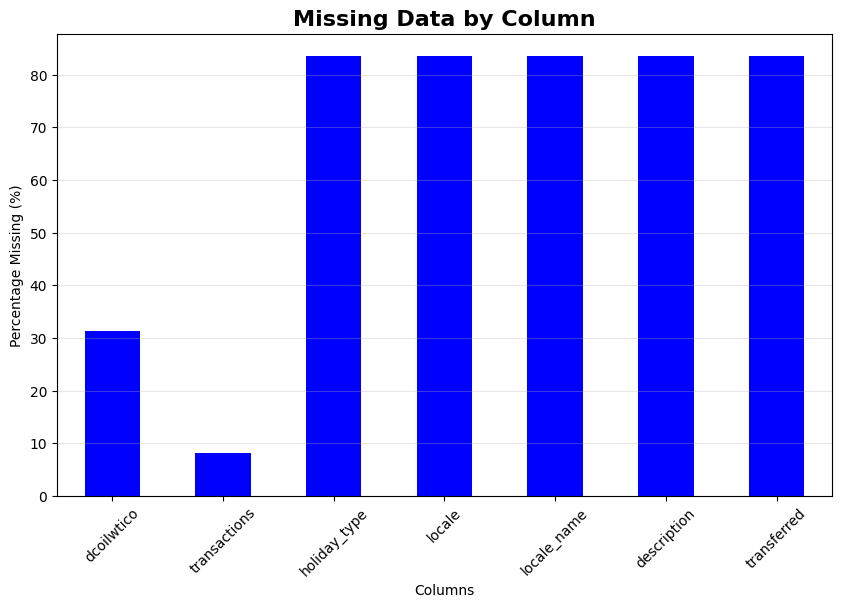

In [15]:
# Check for columns with missing values before Cleanup
print("MISSING VALUES ANALYSIS")
print("=" * 40)
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage': missing_percent
})

print(missing_df[missing_df['Missing Count'] > 0])
print(f"\nTotal missing values: {missing_data.sum()}")
print(f"Percentage of missing data: {(missing_data.sum() / len(df)) * 100:.2f}%")


# Visualize missing data
plt.figure(figsize=(10, 6))
missing_df[missing_df['Missing Count'] > 0]['Percentage'].plot(kind='bar', color='blue')
plt.title('Missing Data by Column', fontsize=16, fontweight='bold')
plt.ylabel('Percentage Missing (%)')
plt.xlabel('Columns')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

In [16]:
# Creating a copy of original data with relevant columns for our predictions and dropping columns with missing data that is irrelevant
df_clean = df.copy()
# Drop the columns locale, locale_name, description, and transferred because it has a lot of NULL values and it is not relevant to fix
df_clean = df_clean.drop(columns = ['locale', 'locale_name', 'description', 'transferred', 'cluster', 'type' ])
df_clean['date'] = pd.to_datetime(df_clean['date'])

In [17]:
# Fix dcoilwtico using forward-fill to keep time continuity
df_clean["dcoilwtico"] = df_clean["dcoilwtico"].fillna(method="ffill").fillna(method="bfill")

# Fix transactions by using median per store
df_clean["transactions"] = df_clean.groupby("store_nbr")["transactions"].transform(
    lambda x: x.fillna(x.median())
)

# Fix is_holiday by adding missing = not a holiday
df_clean["holiday_type"] = df_clean["holiday_type"].fillna("NotHoliday")
# Confirm all missing values are handled
print(df_clean[["dcoilwtico", "transactions", "holiday_type"]].isnull().sum())

dcoilwtico      0
transactions    0
holiday_type    0
dtype: int64


**Adding time based columns to build a Regression Model based on demand over time**

In [18]:
#Checking the number of columns after dropping irrelevante columns
print("Before:", df.shape)
print("After:", df_clean.shape)

Before: (3054348, 17)
After: (3054348, 11)


In [19]:
# Adding time based columns
df_clean["month"] = df_clean["date"].dt.month
df_clean['year'] = df_clean['date'].dt.year
df_clean['weekOfYear'] = df_clean['date'].dt.isocalendar().week
df_clean['quarter'] = df_clean['date'].dt.quarter
df_clean['day'] = df_clean['date'].dt.weekday


Reviewing the Target column, **"sales"**, to ensure data completeness and support the reliability of analytical outcomes

Total rows: 3054348
Missing sales values: 0 (0.00%)
Zero sales values: 953741 (31.23%)
Valid sales values (> 0): 2100607 (68.77%)


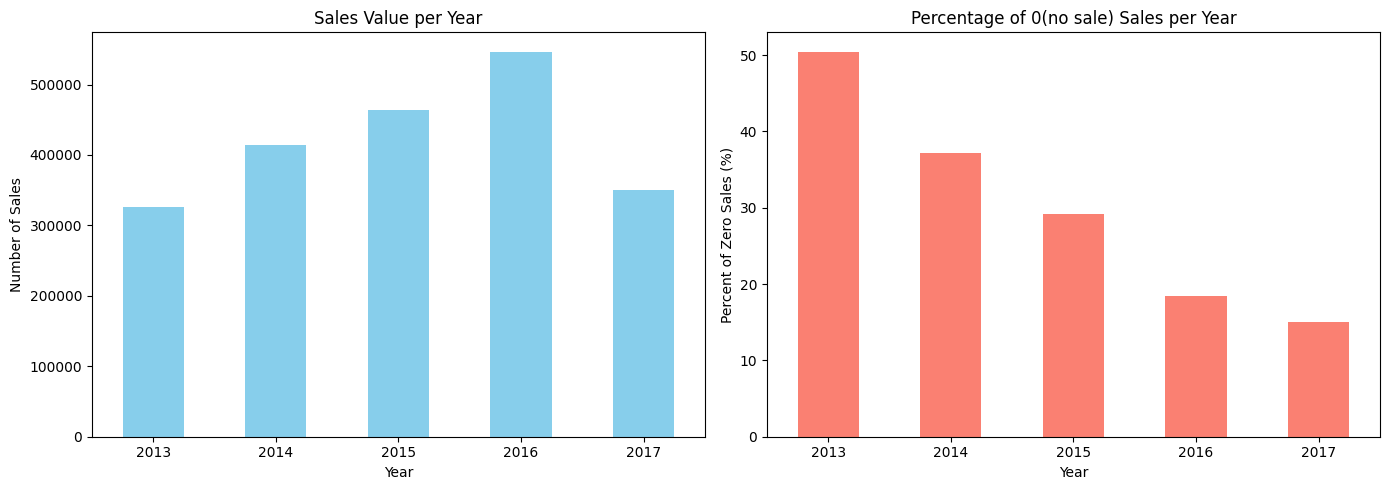

In [20]:
# Total number of rows
total_rows = len(df_clean)

# Count of missing (NaN) values
missing_sales = df_clean['sales'].isna().sum()
missing_sales_pct = (missing_sales / total_rows) * 100
# Count of zero values
zero_sales = (df_clean['sales'] == 0).sum()
zero_sales_pct = (zero_sales / total_rows) * 100

# Count of valid (non-zero, non-NaN) sales
valid_sales_count = df_clean[(df_clean['sales'].notna()) & (df_clean['sales'] > 0)].shape[0]
valid_sales_pct = (valid_sales_count / total_rows) * 100

print(f"Total rows: {total_rows}")
print(f"Missing sales values: {missing_sales} ({missing_sales_pct:.2f}%)")
print(f"Zero sales values: {zero_sales} ({zero_sales_pct:.2f}%)")
print(f"Valid sales values (> 0): {valid_sales_count} ({valid_sales_pct:.2f}%)")


# Group by year and count the sales_values
yearly_sales_count = df_clean[df_clean['sales'] > 0].groupby('year')['sales'].count().sort_index()
# Total sales_values per year
total_per_year = df_clean.groupby('year').size()

# Rows with 0 sales per year
zero_sales_per_year = df_clean[df_clean['sales'] == 0].groupby('year').size()
# Percentage of 0 sales
zero_sales_percentage = (zero_sales_per_year / total_per_year * 100).fillna(0).sort_index()

# Plotting Sales_values and percentage of sales column with 0(no sale).
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Valid Sales per Year
yearly_sales_count.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Sales Value per Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Sales')
axes[0].tick_params(axis='x', rotation=0)

# Plot 2: % of Zero/no Sales per Year
zero_sales_percentage.plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title('Percentage of 0(no sale) Sales per Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Percent of Zero Sales (%)')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

Filtering the past two years of structured data to develop my AI Agent

In [21]:
# Create a datetime column from year and month (using day=1)
df_clean['date'] = pd.to_datetime(df_clean[['year', 'month']].assign(day=1))

# Define range
start_date = pd.to_datetime('2015-08-01')
end_date = pd.to_datetime('2017-08-31')

# Filtering the DataFrame
df_filtered = df_clean[(df_clean['date'] >= start_date) & (df_clean['date'] <= end_date)]
total_rows = len(df_filtered)

# Count of missing (NaN) values
missing_sales = df_filtered['sales'].isna().sum()
missing_sales_pct = (missing_sales / total_rows) * 100
# Count of zero values
zero_sales = (df_filtered['sales'] == 0).sum()
zero_sales_pct = (zero_sales / total_rows) * 100

# Count of valid (non-zero, non-NaN) sales
valid_sales_count = df_filtered[(df_filtered['sales'].notna()) & (df_filtered['sales'] > 0)].shape[0]
valid_sales_pct = (valid_sales_count / total_rows) * 100

# Print results
print(f"Total rows: {total_rows}")
print(f"Missing sales values: {missing_sales} ({missing_sales_pct:.2f}%)")
print(f"Zero sales values: {zero_sales} ({zero_sales_pct:.2f}%)")
print(f"Valid sales values (> 0): {valid_sales_count} ({valid_sales_pct:.2f}%)")
# Check result
print(df_filtered['year'].value_counts())

Total rows: 1354320
Missing sales values: 0 (0.00%)
Zero sales values: 238259 (17.59%)
Valid sales values (> 0): 1116061 (82.41%)
year
2016    670032
2017    411642
2015    272646
Name: count, dtype: int64


In [22]:
# Check for duplicates
print("🔄 DUPLICATE ANALYSIS")
print("=" * 40)
duplicates = df_filtered.duplicated().sum()
print(f"Total duplicate rows: {duplicates:,}")
print(f"Percentage of duplicates: {(duplicates/len(df_filtered)*100):.2f}%")

if duplicates > 0:
    print("\n📋 Sample duplicate rows:")
    print(df_filtered[df_filtered.duplicated()].head())

🔄 DUPLICATE ANALYSIS
Total duplicate rows: 14,256
Percentage of duplicates: 1.05%

📋 Sample duplicate rows:
              id       date  store_nbr      family  sales  onpromotion   city  \
2206117  2174040 2016-05-01          1  AUTOMOTIVE    5.0            0  Quito   
2206119  2174041 2016-05-01          1   BABY CARE    0.0            0  Quito   
2206121  2174042 2016-05-01          1      BEAUTY    0.0            0  Quito   
2206123  2174043 2016-05-01          1   BEVERAGES  856.0            6  Quito   
2206125  2174044 2016-05-01          1       BOOKS    0.0            0  Quito   

             state  dcoilwtico  transactions holiday_type  month  year  \
2206117  Pichincha       44.58         586.0        Event      5  2016   
2206119  Pichincha       44.58         586.0        Event      5  2016   
2206121  Pichincha       44.58         586.0        Event      5  2016   
2206123  Pichincha       44.58         586.0        Event      5  2016   
2206125  Pichincha       44.58     

In [28]:
# Dropping duplicate rows
df_filtered = df_filtered.drop_duplicates()
duplicates = df_filtered.duplicated().sum()
print(f"Total duplicate rows: {duplicates:,}")
print(f"Percentage of duplicates: {(duplicates/len(df_filtered)*100):.2f}%")

Total duplicate rows: 0
Percentage of duplicates: 0.00%


In [29]:
# Check if we dont have negative sales that is referent to
print(f"Negative sales: {len(df_filtered[df_filtered['sales'] < 0])}")

# Verifying if there is any missing_values after cleaning
missing_values = df_filtered.isnull().sum()
# Drop Null Values
df_filtered.dropna(inplace=True)

print(f"\nTotal missing values after cleaning: {missing_values.sum()}")
print(f"Percentage of missing data: {(missing_values.sum() / len(df_filtered)) * 100:.2f}%")

Negative sales: 0

Total missing values after cleaning: 0
Percentage of missing data: 0.00%


In [30]:
# Examine unique values in key columns to make sure columns data make sense
print("UNIQUE VALUES ANALYSIS")
print("=" * 25)
unique_count = df_filtered.nunique()
print(unique_count)

UNIQUE VALUES ANALYSIS
id              1325808
date                 25
store_nbr            54
family               33
sales            221940
onpromotion         362
city                 22
state                16
dcoilwtico          446
transactions       4442
holiday_type          7
month                12
year                  3
weekOfYear           53
quarter               4
day                   7
dtype: int64


In [31]:
df_filtered.shape

(1340064, 16)

## 3. Exploratoy Data Analysis and Visualization

Histogram and Box Plot of Target variable

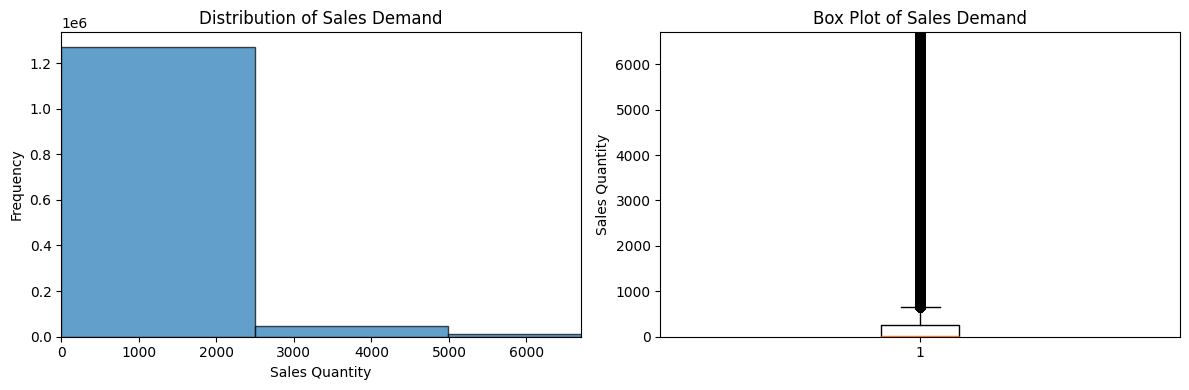

Sales Demand Statistics:
Mean: 455.95
Median: 24.00
Standard Deviation: 1312.78
count    1.340064e+06
mean     4.559517e+02
std      1.312784e+03
min      0.000000e+00
25%      2.000000e+00
50%      2.400000e+01
75%      2.629865e+02
max      1.247170e+05
Name: sales, dtype: float64


In [32]:
# Setting upper limt to limit the data viz for a 99th percentile range
upper_limit = df_filtered['sales'].quantile(0.99)

plt.figure(figsize=(12, 4))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(df_filtered['sales'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Sales Demand')
plt.xlabel('Sales Quantity')
plt.ylabel('Frequency')
plt.xlim(0, upper_limit)  # Setting x-axis limit to filter out extreme values

# Boxplot
plt.subplot(1, 2, 2)
plt.boxplot(df_filtered['sales'], vert=True)
plt.title('Box Plot of Sales Demand')
plt.ylabel('Sales Quantity')
plt.ylim(0, upper_limit)  # Keep consistent with histogram

plt.tight_layout()
plt.show()

# Print summary statistics
print("Sales Demand Statistics:")
print(f"Mean: {df_filtered['sales'].mean():.2f}")
print(f"Median: {df_filtered['sales'].median():.2f}")
print(f"Standard Deviation: {df_filtered['sales'].std():.2f}")

print(df_filtered['sales'].describe())

### Create a Correlation matrix and plot a Heatmap

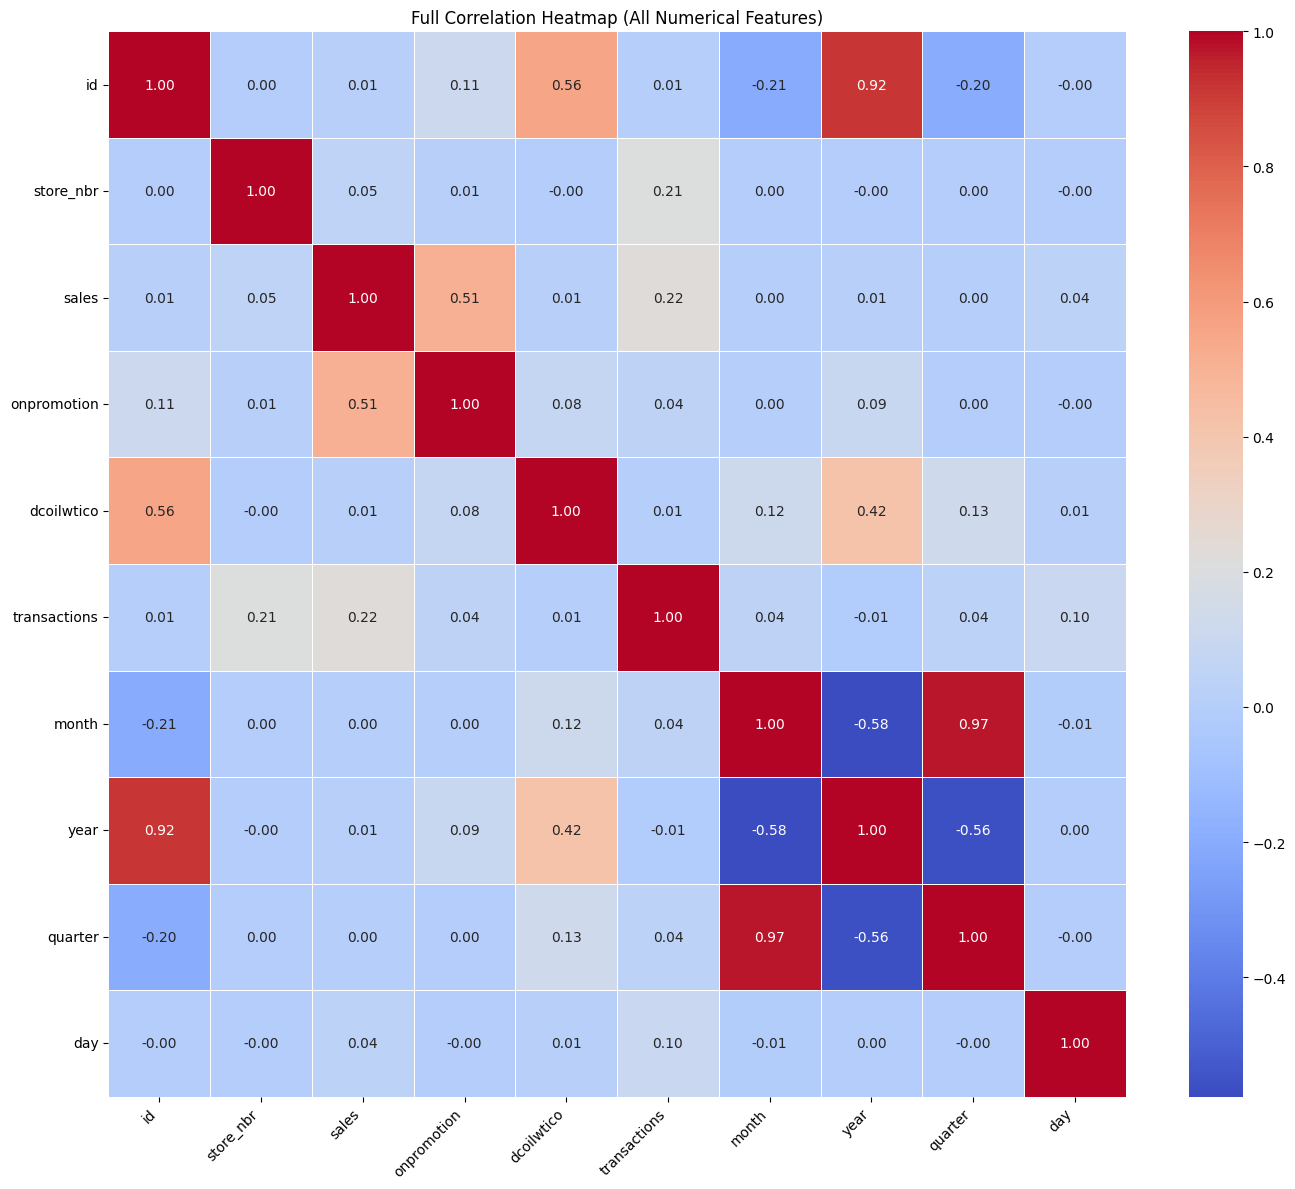

Correlations with Sales (sorted by absolute value):
onpromotion     0.510150
transactions    0.224269
store_nbr       0.048702
day             0.036963
id              0.013342
year            0.010350
dcoilwtico      0.009213
month           0.002725
quarter         0.002221
Name: sales, dtype: float64


,id,store_nbr,sales,onpromotion,dcoilwtico,transactions,month,year,quarter,day
id,1.000000,6.845273e-04,0.013342,0.108256,5.608506e-01,0.005231,-2.058454e-01,9.174353e-01,-1.981994e-01,-2.516969e-03
store_nbr,0.000685,1.000000e+00,0.048702,0.011387,-1.172415e-14,0.205614,7.221143e-15,-4.633052e-14,7.660434e-15,-1.865716e-17
sales,0.013342,4.870225e-02,1.000000,0.510150,9.213382e-03,0.224269,2.725244e-03,1.034953e-02,2.221287e-03,3.696267e-02
onpromotion,0.108256,1.138697e-02,0.510150,1.000000,7.813260e-02,0.040809,2.854660e-03,8.897048e-02,1.567214e-03,-3.699108e-03
dcoilwtico,0.560851,-1.172415e-14,0.009213,0.078133,1.000000e+00,0.006328,1.181025e-01,4.204257e-01,1.293888e-01,9.147839e-03
transactions,0.005231,2.056138e-01,0.224269,0.040809,6.328220e-03,1.000000,4.391527e-02,-1.333590e-02,3.628804e-02,9.521919e-02
month,-0.205845,7.221143e-15,0.002725,0.002855,1.181025e-01,0.043915,1.000000e+00,-5.767694e-01,9.715277e-01,-8.208043e-03
year,0.917435,-4.633052e-14,0.010350,0.088970,4.204257e-01,-0.013336,-5.767694e-01,1.000000e+00,-5.589686e-01,1.515615e-03
quarter,-0.198199,7.660434e-15,0.002221,0.001567,1.293888e-01,0.036288,9.715277e-01,-5.589686e-01,1.000000e+00,-6.421363e-04
day,-0.002517,-1.865716e-17,0.036963,-0.003699,9.147839e-03,0.095219,-8.208043e-03,1.515615e-03,-6.421363e-04,1.000000e+00


In [33]:
# Step 1: Extract only numeric columns
df_filtered_numeric = df_filtered.select_dtypes(include=["int32", "int64", "float64"])

# Step 2: Compute full correlation matrix
corr_matrix = df_filtered_numeric.corr()

# Step 3: Plot the full heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Full Correlation Heatmap (All Numerical Features)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Show correlations with target variable
print("Correlations with Sales (sorted by absolute value):")
Sales_correlations = corr_matrix['sales'].drop(['sales']).sort_values(key=abs, ascending=False)
print(Sales_correlations)
corr_matrix

### Scatter plots of most correlated features


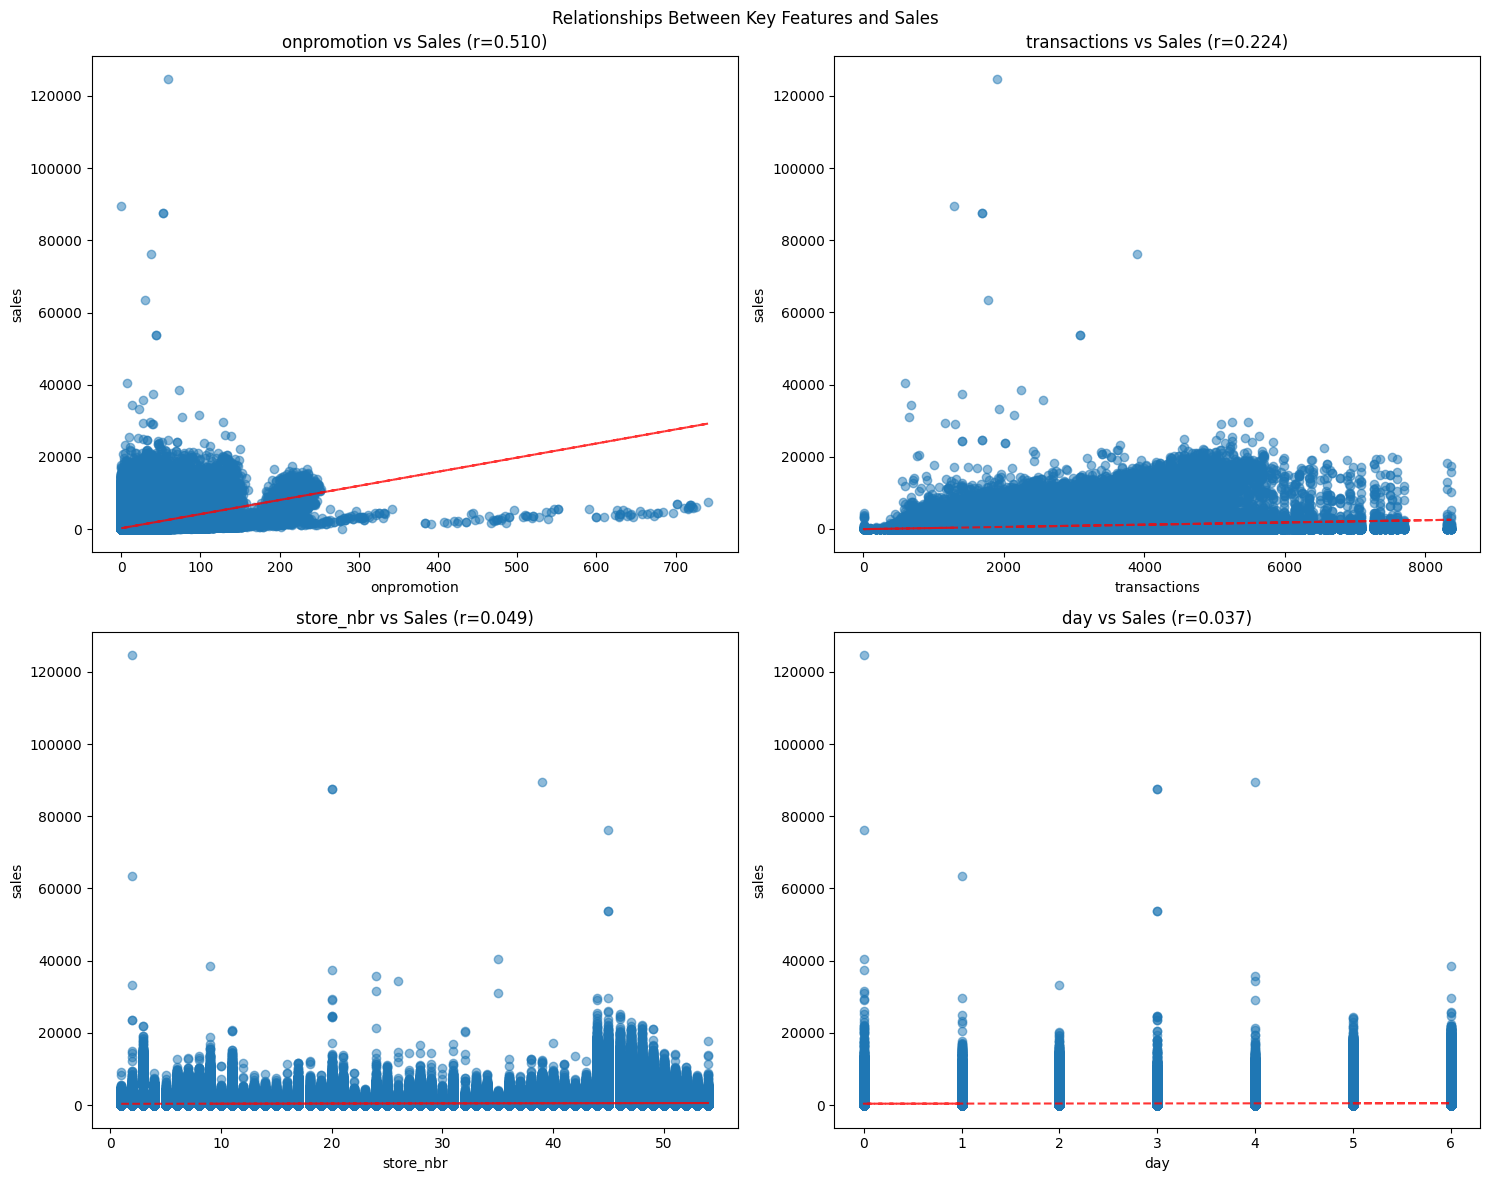

In [34]:
# Scatter plots of most correlated features
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Relationships Between Key Features and Sales')

# Get top 4 most correlated features (by absolute value)
top_features = Sales_correlations.head(4).index

for i, feature in enumerate(top_features):
    row = i // 2
    col = i % 2

    axes[row, col].scatter(df_filtered_numeric[feature], df_filtered_numeric['sales'], alpha=0.5)
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('sales')
    axes[row, col].set_title(f'{feature} vs Sales (r={Sales_correlations[feature]:.3f})')

    # Add trend line
    z = np.polyfit(df_filtered_numeric[feature], df_filtered_numeric['sales'], 1)
    p = np.poly1d(z)
    axes[row, col].plot(df_filtered_numeric[feature], p(df_filtered_numeric[feature]), "r--", alpha=0.8)


plt.tight_layout()
plt.show()

## 4. Data Preprocessing

### Feature Engineering and Categorical Encoding

In [35]:
# Create a copy for data processing
df_processed = df_filtered.copy()

# Create new seasonal columns
df_processed['WeekPart'] = pd.cut(df_clean['day'],
                               bins=[-1, 2, 4, 6],
                               labels=['EarlyWeek', 'MidWeek', 'Weekend'])

# Map the month according to seasons
season_map = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
}

df_processed['MonthSeason'] = df_processed['month'].map(season_map)

print("New categorical features created:")
print("\nWeekly distribution:")
print(df_processed['WeekPart'].value_counts())

print("\nSeason distribution:")
print(df_processed['MonthSeason'].value_counts())

New categorical features created:

Weekly distribution:
WeekPart
EarlyWeek    572022
Weekend      386694
MidWeek      381348
Name: count, dtype: int64

Season distribution:
MonthSeason
Summer    356400
Spring    335016
Fall      326106
Winter    322542
Name: count, dtype: int64


Getting columns ready for hot-encoding

In [36]:
# Grouping Family Categories into small batches for easier One-Hot Encoding
food_families = ['BREAD/BAKERY', 'DAIRY', 'MEATS', 'PRODUCE', 'FROZEN FOODS',
    'DELI', 'GROCERY I', 'GROCERY II', 'EGGS', 'SEAFOOD',
    'PREPARED FOODS', 'POULTRY']
beverage_families = ['BEVERAGES', 'LIQUOR,WINE,BEER']

personal_families = ['PERSONAL CARE', 'BEAUTY', 'BABY CARE', 'CLEANING', 'HOME CARE']

home_families = ['HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
    'HARDWARE', 'AUTOMOTIVE' ]
apparel_families = ['LADIESWEAR', 'LINGERIE']

# Build a mapping dictionary to store the Family Category
family_group_map = {}
for family in food_families:
    family_group_map[family] = 'Food'

for family in beverage_families:
    family_group_map[family] = 'Beverages'

for family in personal_families:
    family_group_map[family] = 'Personal'

for family in home_families:
    family_group_map[family] = 'Home'

for family in apparel_families:
    family_group_map[family] = 'Apparel'

# Apply the mapping
df_processed['family_grouped'] = df_processed['family'].map(family_group_map).fillna('Other')

# Check result
print("Grouped family category counts:")
print(df_processed['family_grouped'].value_counts())


Grouped family category counts:
family_grouped
Food         487296
Other        284256
Personal     203040
Home         203040
Beverages     81216
Apparel       81216
Name: count, dtype: int64


In [37]:
# Group cities by the the top ten the others would be rare
top_cities = df_processed['city'].value_counts().nlargest(10).index
df_processed['city_grouped'] = df_processed['city'].where(df_processed['city'].isin(top_cities), 'Other')

In [38]:
df_processed

,id,date,store_nbr,family,sales,onpromotion,city,state,dcoilwtico,transactions,holiday_type,month,year,weekOfYear,quarter,day,WeekPart,MonthSeason,family_grouped,city_grouped
1700028,1675080,2015-08-01,1,AUTOMOTIVE,4.000,0,Quito,Pichincha,47.11,1287.0,NotHoliday,8,2015,31,3,5,Weekend,Summer,Home,Quito
1700029,1675081,2015-08-01,1,BABY CARE,0.000,0,Quito,Pichincha,47.11,1287.0,NotHoliday,8,2015,31,3,5,Weekend,Summer,Personal,Quito
1700030,1675082,2015-08-01,1,BEAUTY,6.000,0,Quito,Pichincha,47.11,1287.0,NotHoliday,8,2015,31,3,5,Weekend,Summer,Personal,Quito
1700031,1675083,2015-08-01,1,BEVERAGES,2191.000,2,Quito,Pichincha,47.11,1287.0,NotHoliday,8,2015,31,3,5,Weekend,Summer,Beverages,Quito
1700032,1675084,2015-08-01,1,BOOKS,0.000,0,Quito,Pichincha,47.11,1287.0,NotHoliday,8,2015,31,3,5,Weekend,Summer,Other,Quito
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-01,9,POULTRY,438.133,0,Quito,Pichincha,47.57,2155.0,Holiday,8,2017,33,3,1,EarlyWeek,Summer,Food,Quito
3054344,3000884,2017-08-01,9,PREPARED FOODS,154.553,1,Quito,Pichincha,47.57,2155.0,Holiday,8,2017,33,3,1,EarlyWeek,Summer,Food,Quito
3054345,3000885,2017-08-01,9,PRODUCE,2419.729,148,Quito,Pichincha,47.57,2155.0,Holiday,8,2017,33,3,1,EarlyWeek,Summer,Food,Quito
3054346,3000886,2017-08-01,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,47.57,2155.0,Holiday,8,2017,33,3,1,EarlyWeek,Summer,Other,Quito


In [39]:
# One-Hot Encoding for categorical variables
print("Before one-hot encoding:")
print(f"Shape: {df_processed.shape}")
print(f"Columns: {list(df_processed.columns)}")

# Apply one-hot encoding
onehot_cols = ['WeekPart', 'MonthSeason', 'holiday_type','family_grouped','city_grouped', 'state']

df_encoded = pd.get_dummies(df_processed, columns=onehot_cols, prefix=onehot_cols, drop_first=True)
# Drop original categorical columns
df_encoded = df_encoded.drop(columns=['family', 'city', 'date'], errors='ignore')

print("\nAfter one-hot encoding:")
print(f"Shape: {df_encoded.shape}")
print(f"New columns added: {[col for col in df_encoded.columns if col not in df_processed.columns]}")

df_encoded.head()
# for boolean values 1=True and 0=False

Before one-hot encoding:
Shape: (1340064, 20)
Columns: ['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city', 'state', 'dcoilwtico', 'transactions', 'holiday_type', 'month', 'year', 'weekOfYear', 'quarter', 'day', 'WeekPart', 'MonthSeason', 'family_grouped', 'city_grouped']

After one-hot encoding:
Shape: (1340064, 52)
New columns added: ['WeekPart_MidWeek', 'WeekPart_Weekend', 'MonthSeason_Spring', 'MonthSeason_Summer', 'MonthSeason_Winter', 'holiday_type_Bridge', 'holiday_type_Event', 'holiday_type_Holiday', 'holiday_type_NotHoliday', 'holiday_type_Transfer', 'holiday_type_Work Day', 'family_grouped_Beverages', 'family_grouped_Food', 'family_grouped_Home', 'family_grouped_Other', 'family_grouped_Personal', 'city_grouped_Cayambe', 'city_grouped_Cuenca', 'city_grouped_Guayaquil', 'city_grouped_Latacunga', 'city_grouped_Machala', 'city_grouped_Manta', 'city_grouped_Other', 'city_grouped_Quito', 'city_grouped_Riobamba', 'city_grouped_Santo Domingo', 'state_Bolivar', 'state

,id,store_nbr,sales,onpromotion,dcoilwtico,transactions,month,year,weekOfYear,quarter,day,WeekPart_MidWeek,WeekPart_Weekend,MonthSeason_Spring,MonthSeason_Summer,MonthSeason_Winter,holiday_type_Bridge,holiday_type_Event,holiday_type_Holiday,holiday_type_NotHoliday,holiday_type_Transfer,holiday_type_Work Day,family_grouped_Beverages,family_grouped_Food,family_grouped_Home,family_grouped_Other,family_grouped_Personal,city_grouped_Cayambe,city_grouped_Cuenca,city_grouped_Guayaquil,city_grouped_Latacunga,city_grouped_Machala,city_grouped_Manta,city_grouped_Other,city_grouped_Quito,city_grouped_Riobamba,city_grouped_Santo Domingo,state_Bolivar,state_Chimborazo,state_Cotopaxi,state_El Oro,state_Esmeraldas,state_Guayas,state_Imbabura,state_Loja,state_Los Rios,state_Manabi,state_Pastaza,state_Pichincha,state_Santa Elena,state_Santo Domingo de los Tsachilas,state_Tungurahua
1700028,1675080,1,4.0,0,47.11,1287.0,8,2015,31,3,5,False,True,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1700029,1675081,1,0.0,0,47.11,1287.0,8,2015,31,3,5,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1700030,1675082,1,6.0,0,47.11,1287.0,8,2015,31,3,5,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1700031,1675083,1,2191.0,2,47.11,1287.0,8,2015,31,3,5,False,True,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1700032,1675084,1,0.0,0,47.11,1287.0,8,2015,31,3,5,False,True,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


In [40]:
# Check for columns with missing values After Cleanup
print("MISSING VALUES ANALYSIS")
print("=" * 40)
missing_data = df_encoded.isnull().sum()
missing_percent = (missing_data / len(df_encoded)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage': missing_percent
})

print(missing_df[missing_df['Missing Count'] > 0])
print(f"\nTotal missing values: {missing_data.sum()}")
print(f"Percentage of missing data: {(missing_data.sum() / len(df_encoded)) * 100:.2f}%")



MISSING VALUES ANALYSIS
Empty DataFrame
Columns: [Missing Count, Percentage]
Index: []

Total missing values: 0
Percentage of missing data: 0.00%


In [41]:
# Examine unique values in key columns to make sure columns data make sense
print("UNIQUE VALUES ANALYSIS")
print("=" * 25)
unique_count = df_encoded.nunique()
print(unique_count)

UNIQUE VALUES ANALYSIS
id                                      1325808
store_nbr                                    54
sales                                    221940
onpromotion                                 362
dcoilwtico                                  446
transactions                               4442
month                                        12
year                                          3
weekOfYear                                   53
quarter                                       4
day                                           7
WeekPart_MidWeek                              2
WeekPart_Weekend                              2
MonthSeason_Spring                            2
MonthSeason_Summer                            2
MonthSeason_Winter                            2
holiday_type_Bridge                           2
holiday_type_Event                            2
holiday_type_Holiday                          2
holiday_type_NotHoliday                       2
holiday_type_Tran

In [42]:
df_encoded.to_csv("processed_sales_data.csv.gz", index=False, compression="gzip")


In [43]:
# Load your big processed dataset
df = pd.read_csv("processed_sales_data.csv.gz")

# Take a smaller random sample (e.g., 5,000 rows)
df_small = df.sample(10000, random_state=42)

# Save it as a gzip-compressed CSV
df_small.to_csv("processed_sales_data_small.csv.gz", index=False, compression="gzip")

print(f"✅ Saved processed_sales_data_small.csv.gz with {len(df_small):,} rows")


✅ Saved processed_sales_data_small.csv.gz with 10,000 rows


In [44]:
import os

# Path to your file
file_path = "processed_sales_data_small.csv.gz"  # or .zip, .csv, etc.

# Get size in bytes
size_bytes = os.path.getsize(file_path)

# Convert to megabytes
size_mb = size_bytes / (1024 * 1024)

print(f"File size: {size_mb:.2f} MB")



File size: 0.22 MB


### Train-Test Split

In [45]:
# Separate features and target
X = df_encoded.drop('sales', axis=1)
y = df_encoded['sales']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature names: {list(X.columns)}")
print(f"\nTarget name: {y.name}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Testing target shape: {y_test.shape}")

Features shape: (1340064, 51)
Target shape: (1340064,)

Feature names: ['id', 'store_nbr', 'onpromotion', 'dcoilwtico', 'transactions', 'month', 'year', 'weekOfYear', 'quarter', 'day', 'WeekPart_MidWeek', 'WeekPart_Weekend', 'MonthSeason_Spring', 'MonthSeason_Summer', 'MonthSeason_Winter', 'holiday_type_Bridge', 'holiday_type_Event', 'holiday_type_Holiday', 'holiday_type_NotHoliday', 'holiday_type_Transfer', 'holiday_type_Work Day', 'family_grouped_Beverages', 'family_grouped_Food', 'family_grouped_Home', 'family_grouped_Other', 'family_grouped_Personal', 'city_grouped_Cayambe', 'city_grouped_Cuenca', 'city_grouped_Guayaquil', 'city_grouped_Latacunga', 'city_grouped_Machala', 'city_grouped_Manta', 'city_grouped_Other', 'city_grouped_Quito', 'city_grouped_Riobamba', 'city_grouped_Santo Domingo', 'state_Bolivar', 'state_Chimborazo', 'state_Cotopaxi', 'state_El Oro', 'state_Esmeraldas', 'state_Guayas', 'state_Imbabura', 'state_Loja', 'state_Los Rios', 'state_Manabi', 'state_Pastaza', 'sta

In [46]:
# X_train.to_csv("X_train.csv", index=False)
# y_train.to_csv("y_train.csv", index=False)
# After preprocessing, before scaling
#df_encoded.to_csv("processed_sales_data.csv", index=False)
X_train.to_csv("X_train.csv.gz", index=False, compression="gzip")
y_train.to_csv("y_train.csv.gz", index=False, compression="gzip")



### Feature Scaling

In [47]:
# Feature scaling using StandardScaler
print("Before scaling - Training set statistics:")
print(X_train.describe())

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\nAfter scaling - Training set statistics:")
print(X_train_scaled.describe())

# Show the effect of scaling on a few features
print("\nScaling effect comparison:")
scaling_comparison = pd.DataFrame({
    'Original_Mean': X_train.mean(),
    'Original_Std': X_train.std(),
    'Scaled_Mean': X_train_scaled.mean(),
    'Scaled_Std': X_train_scaled.std()
})
print(scaling_comparison.head(8))

Before scaling - Training set statistics:
                 id     store_nbr   onpromotion    dcoilwtico  transactions  \
count  1.072051e+06  1.072051e+06  1.072051e+06  1.072051e+06  1.072051e+06   
mean   2.336597e+06  2.750240e+01  5.201748e+00  4.504675e+01  1.659854e+03   
std    3.813538e+05  1.558364e+01  1.715057e+01  6.040903e+00  9.498350e+02   
min    1.675080e+06  1.000000e+00  0.000000e+00  2.619000e+01  5.000000e+00   
25%    2.007690e+06  1.400000e+01  0.000000e+00  4.245000e+01  1.019000e+03   
50%    2.333814e+06  2.800000e+01  0.000000e+00  4.602000e+01  1.368000e+03   
75%    2.665276e+06  4.100000e+01  2.000000e+00  4.922000e+01  2.037000e+03   
max    3.000887e+06  5.400000e+01  7.410000e+02  5.448000e+01  8.359000e+03   

              month          year  weekOfYear       quarter           day  
count  1.072051e+06  1.072051e+06   1072051.0  1.072051e+06  1.072051e+06  
mean   6.546828e+00  2.016098e+03    26.80891  2.517644e+00  3.004642e+00  
std    3.415561e+0

## 4. Model Building and Training

### 4.1 Simple Linear Regression (Most Correlated Feature)

In [48]:
# Build a simple linear regression model using the most correlated feature
best_feature = Sales_correlations.abs().idxmax()
print(f"Using {best_feature} for simple linear regression (correlation: {Sales_correlations[best_feature]:.3f})")

# Simple linear regression
simple_model = LinearRegression()
simple_model.fit(X_train_scaled[[best_feature]], y_train)

# Make predictions
y_pred_simple_train = simple_model.predict(X_train_scaled[[best_feature]])
y_pred_simple_test = simple_model.predict(X_test_scaled[[best_feature]])

# Model parameters
print(f"\nSimple Linear Regression Results:")
print(f"Intercept: {simple_model.intercept_:.4f}")
print(f"Coefficient for {best_feature}: {simple_model.coef_[0]:.4f}")

# Model equation
print(f"\nModel equation: Demand = {simple_model.intercept_:.4f} + {simple_model.coef_[0]:.4f} * {best_feature}")

Using onpromotion for simple linear regression (correlation: 0.510)

Simple Linear Regression Results:
Intercept: 456.5832
Coefficient for onpromotion: 670.8680

Model equation: Demand = 456.5832 + 670.8680 * onpromotion


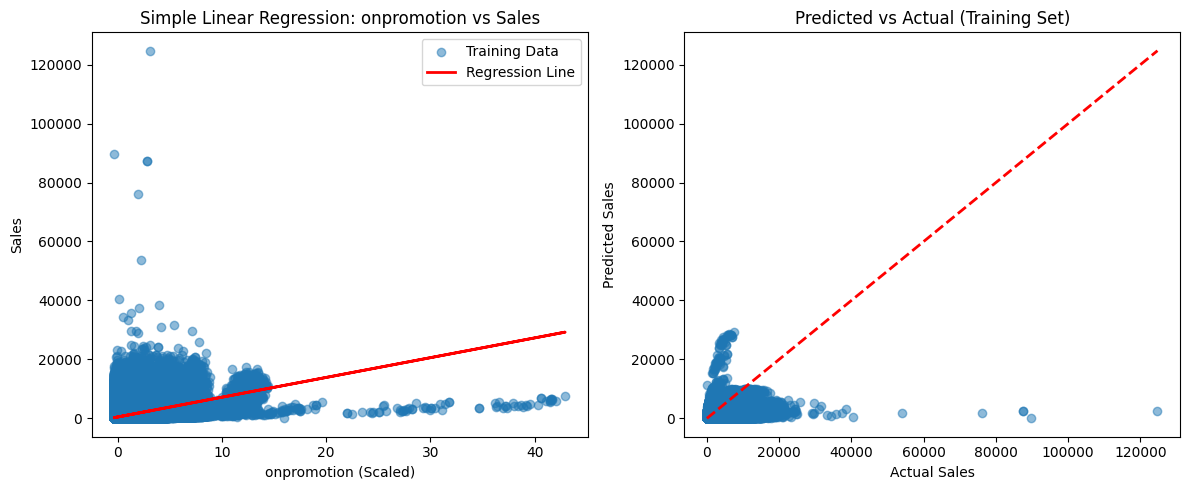

In [49]:
# Visualize simple linear regression
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_train_scaled[best_feature], y_train, alpha=0.5, label='Training Data')
plt.plot(X_train_scaled[best_feature], y_pred_simple_train, color='red', linewidth=2, label='Regression Line')
plt.xlabel(f'{best_feature} (Scaled)')
plt.ylabel('Sales')
plt.title(f'Simple Linear Regression: {best_feature} vs Sales')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_train, y_pred_simple_train, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', linewidth=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Predicted vs Actual (Training Set)')

plt.tight_layout()
plt.show()

### 4.2 Multiple Linear Regression

In [50]:
# Multiple linear regression using all features
multiple_model = LinearRegression()
multiple_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_multiple_train = multiple_model.predict(X_train_scaled)
y_pred_multiple_test = multiple_model.predict(X_test_scaled)

# Calculate performance metrics for both training and testing test
# y_true/y_test represents the y_test(20%) predicted to be the true value
def calculate_metrics(y_true, y_pred, dataset):
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_true, y_pred)
  r2 = r2_score(y_true, y_pred)

  print('Performance Metrics for', dataset, 'Set:')
  print(f'Mean Squared Error (MSE): {mse:.4f}')
  print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
  print(f'Mean Absolute Error (MAE): {mae:.4f}')
  print(f'R-squared (R²): {r2:.4f}')

# Trainig test performance. How the model performed on data seen before
print("=== TRAINING SET PERFORMANCE ===")
calculate_metrics(y_train, y_pred_multiple_train, "Training")

# Testing test performance. How the model performed on data not seen before
print("=== Testing SET PERFORMANCE ===")
calculate_metrics(y_test, y_pred_multiple_test, "Testing")

=== TRAINING SET PERFORMANCE ===
Performance Metrics for Training Set:
Mean Squared Error (MSE): 1094350.4929
Root Mean Squared Error (RMSE): 1046.1121
Mean Absolute Error (MAE): 476.7505
R-squared (R²): 0.3683
=== Testing SET PERFORMANCE ===
Performance Metrics for Testing Set:
Mean Squared Error (MSE): 1059590.6591
Root Mean Squared Error (RMSE): 1029.3642
Mean Absolute Error (MAE): 475.0388
R-squared (R²): 0.3721


In [51]:
#Save the my trained model to a file
 # Train your model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Save it to a file
joblib.dump(model, 'linear_model.pkl')

['linear_model.pkl']

In [52]:
# Saving the features names to a file
import joblib
joblib.dump(list(X_train_scaled.columns), "model_features.pkl")

['model_features.pkl']

In [53]:
# Create a DataFrame to show Multiple Regression coefficients
print("Multiple Linear Regression Results:")
print(f"Intercept: {multiple_model.intercept_:.4f}")
print("\nCoefficients:")

# Create a DataFrame to show coefficients
coefficients_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': multiple_model.coef_
})
coefficients_df['Abs_Coefficient'] = abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values('Abs_Coefficient', ascending=False)

print(coefficients_df.head(10))

Multiple Linear Regression Results:
Intercept: 456.5832

Coefficients:
                     Feature  Coefficient  Abs_Coefficient
2                onpromotion   595.206361       595.206361
6                       year   356.722280       356.722280
0                         id  -344.817600       344.817600
21  family_grouped_Beverages   308.399802       308.399802
4               transactions   254.704164       254.704164
22       family_grouped_Food   220.549220       220.549220
11          WeekPart_Weekend   176.575502       176.575502
5                      month   127.572813       127.572813
9                        day  -123.279778       123.279778
25   family_grouped_Personal    60.655991        60.655991


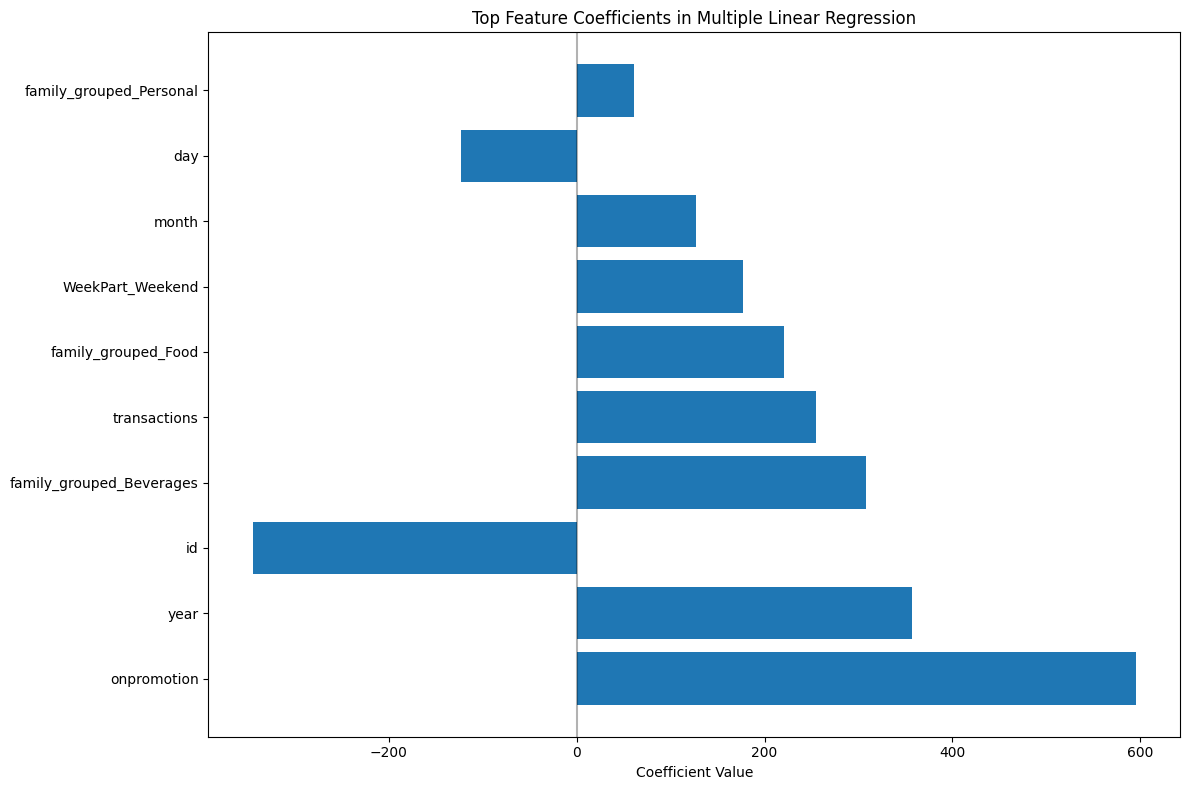


Coefficient Interpretation:
- Positive coefficients: Increase in feature leads to increase in Sales
- Negative coefficients: Increase in feature leads to decrease in Sales
- Larger absolute values: Stronger impact on Sales


In [54]:
# Visualize coefficient importance
plt.figure(figsize=(12, 8))
plt.barh(coefficients_df['Feature'].head(10), coefficients_df['Coefficient'].head(10))
plt.xlabel('Coefficient Value')
plt.title('Top Feature Coefficients in Multiple Linear Regression')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nCoefficient Interpretation:")
print("- Positive coefficients: Increase in feature leads to increase in Sales")
print("- Negative coefficients: Increase in feature leads to decrease in Sales")
print("- Larger absolute values: Stronger impact on Sales")

## 5. Model Evaluation and Performance Metrics

In [55]:
# Calculate performance metrics for both models
def calculate_metrics(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{model_name} Performance Metrics:")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  R-squared (R²): {r2:.4f}")
    print(f"  Explained Variance: {r2*100:.2f}%")
    print()

    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Training set performance
print("=== TRAINING SET PERFORMANCE ===")
simple_train_metrics = calculate_metrics(y_train, y_pred_simple_train, "Simple Linear Regression")
multiple_train_metrics = calculate_metrics(y_train, y_pred_multiple_train, "Multiple Linear Regression")

# Testing set performance
print("=== TESTING SET PERFORMANCE ===")
simple_test_metrics = calculate_metrics(y_test, y_pred_simple_test, "Simple Linear Regression")
multiple_test_metrics = calculate_metrics(y_test, y_pred_multiple_test, "Multiple Linear Regression")

=== TRAINING SET PERFORMANCE ===
Simple Linear Regression Performance Metrics:
  Mean Squared Error (MSE): 1282331.4411
  Root Mean Squared Error (RMSE): 1132.4007
  Mean Absolute Error (MAE): 480.7339
  R-squared (R²): 0.2598
  Explained Variance: 25.98%

Multiple Linear Regression Performance Metrics:
  Mean Squared Error (MSE): 1094350.4929
  Root Mean Squared Error (RMSE): 1046.1121
  Mean Absolute Error (MAE): 476.7505
  R-squared (R²): 0.3683
  Explained Variance: 36.83%

=== TESTING SET PERFORMANCE ===
Simple Linear Regression Performance Metrics:
  Mean Squared Error (MSE): 1245071.9460
  Root Mean Squared Error (RMSE): 1115.8279
  Mean Absolute Error (MAE): 479.0424
  R-squared (R²): 0.2621
  Explained Variance: 26.21%

Multiple Linear Regression Performance Metrics:
  Mean Squared Error (MSE): 1059590.6591
  Root Mean Squared Error (RMSE): 1029.3642
  Mean Absolute Error (MAE): 475.0388
  R-squared (R²): 0.3721
  Explained Variance: 37.21%



Performance Comparison:
      Simple_Train  Simple_Test  Multiple_Train  Multiple_Test
R²        0.259793     0.262141        0.368302       0.372061
RMSE   1132.400742  1115.827920     1046.112084    1029.364201
MAE     480.733917   479.042397      476.750509     475.038763


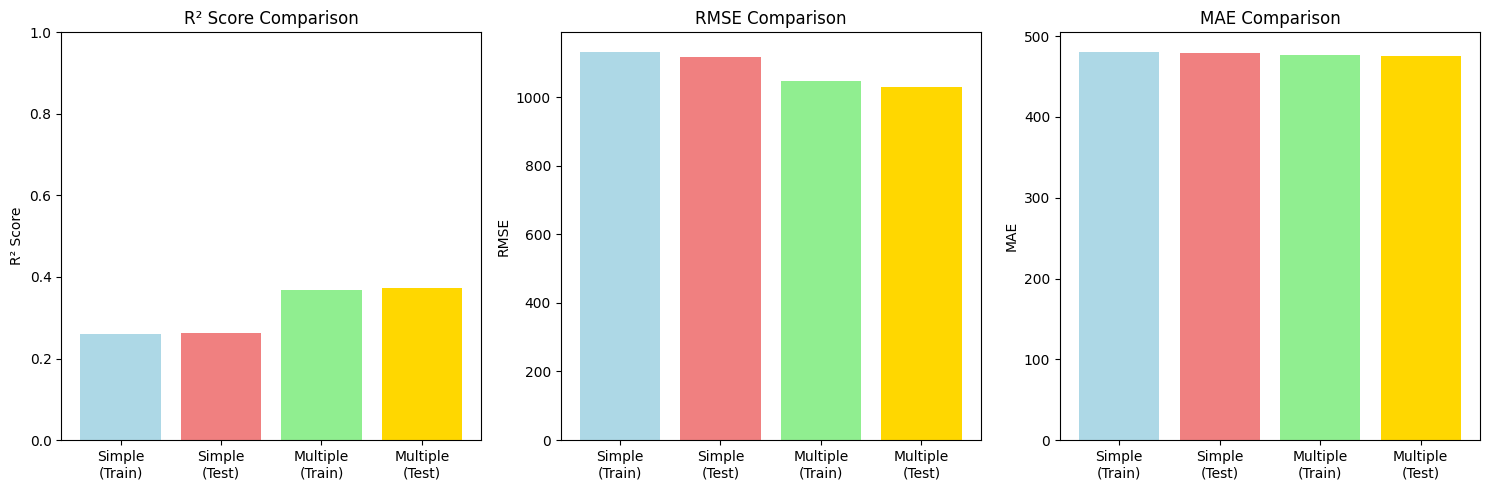

In [56]:
# Performance comparison visualization
metrics_comparison = pd.DataFrame({
    'Simple_Train': [simple_train_metrics['R2'], simple_train_metrics['RMSE'], simple_train_metrics['MAE']],
    'Simple_Test': [simple_test_metrics['R2'], simple_test_metrics['RMSE'], simple_test_metrics['MAE']],
    'Multiple_Train': [multiple_train_metrics['R2'], multiple_train_metrics['RMSE'], multiple_train_metrics['MAE']],
    'Multiple_Test': [multiple_test_metrics['R2'], multiple_test_metrics['RMSE'], multiple_test_metrics['MAE']]
}, index=['R²', 'RMSE', 'MAE'])

print("Performance Comparison:")
print(metrics_comparison)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# R² comparison
r2_data = [simple_train_metrics['R2'], simple_test_metrics['R2'],
           multiple_train_metrics['R2'], multiple_test_metrics['R2']]
labels = ['Simple\n(Train)', 'Simple\n(Test)', 'Multiple\n(Train)', 'Multiple\n(Test)']
axes[0].bar(labels, r2_data, color=['lightblue', 'lightcoral', 'lightgreen', 'gold'])
axes[0].set_title('R² Score Comparison')
axes[0].set_ylabel('R² Score')
axes[0].set_ylim(0, 1)

# RMSE comparison
rmse_data = [simple_train_metrics['RMSE'], simple_test_metrics['RMSE'],
             multiple_train_metrics['RMSE'], multiple_test_metrics['RMSE']]
axes[1].bar(labels, rmse_data, color=['lightblue', 'lightcoral', 'lightgreen', 'gold'])
axes[1].set_title('RMSE Comparison')
axes[1].set_ylabel('RMSE')

# MAE comparison
mae_data = [simple_train_metrics['MAE'], simple_test_metrics['MAE'],
            multiple_train_metrics['MAE'], multiple_test_metrics['MAE']]
axes[2].bar(labels, mae_data, color=['lightblue', 'lightcoral', 'lightgreen', 'gold'])
axes[2].set_title('MAE Comparison')
axes[2].set_ylabel('MAE')

plt.tight_layout()
plt.show()

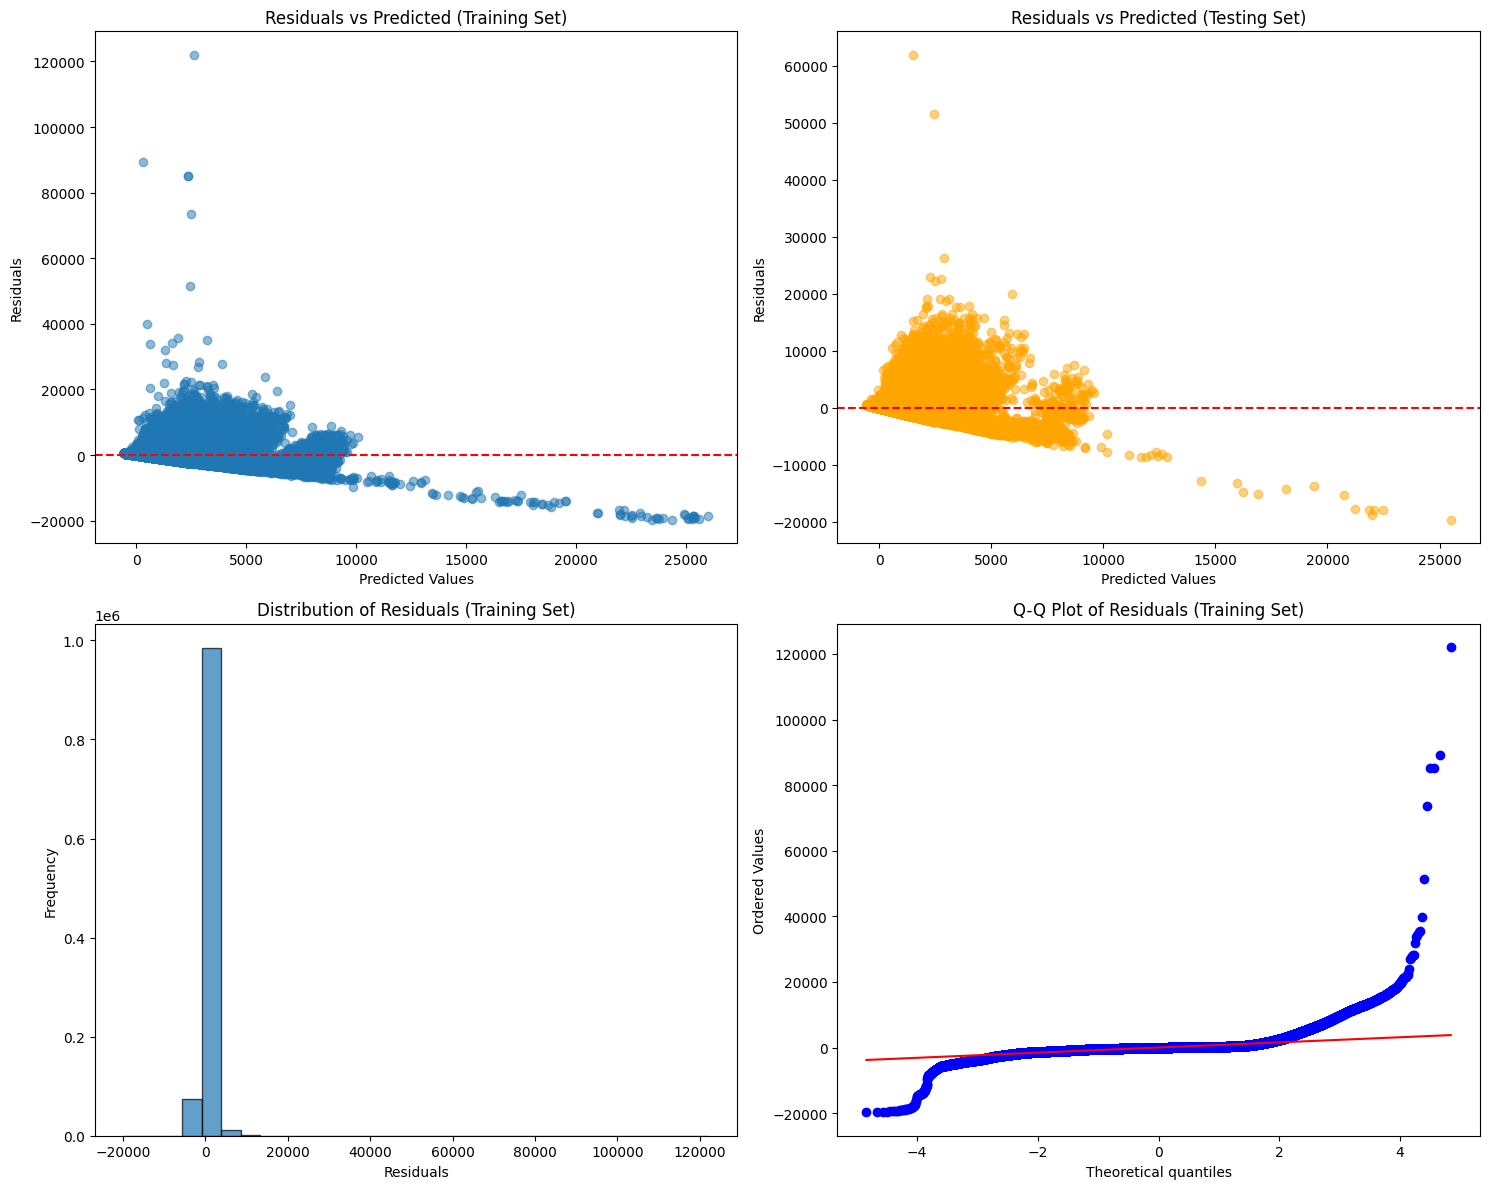

Residual Analysis Insights:
Training set residuals - Mean: -0.0000, Std: 1046.1126
Testing set residuals - Mean: -0.9186, Std: 1029.3657


In [57]:
# Residual analysis for multiple linear regression
residuals_train = y_train - y_pred_multiple_train
residuals_test = y_test - y_pred_multiple_test

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Residuals vs Predicted (Training)
axes[0, 0].scatter(y_pred_multiple_train, residuals_train, alpha=0.5)
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_xlabel('Predicted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Predicted (Training Set)')

# Residuals vs Predicted (Testing)
axes[0, 1].scatter(y_pred_multiple_test, residuals_test, alpha=0.5, color='orange')
axes[0, 1].axhline(y=0, color='red', linestyle='--')
axes[0, 1].set_xlabel('Predicted Values')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residuals vs Predicted (Testing Set)')

# Histogram of residuals (Training)
axes[1, 0].hist(residuals_train, bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Residuals (Training Set)')

# Q-Q plot for normality check
from scipy import stats
stats.probplot(residuals_train, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot of Residuals (Training Set)')

plt.tight_layout()
plt.show()

print("Residual Analysis Insights:")
print(f"Training set residuals - Mean: {residuals_train.mean():.4f}, Std: {residuals_train.std():.4f}")
print(f"Testing set residuals - Mean: {residuals_test.mean():.4f}, Std: {residuals_test.std():.4f}")

Linear regression may not be suitable for this dataset due to significant skewness in the data, which led to a low R-squared value. An alternative model may be considered:

**RGBoost Regression Model** – This model can address nonlinearity more effectively.


In [58]:
!pip install xgboost
import xgboost as xgb

In [59]:
# Feature columns - using the one-hot encoded DataFrame
target = 'sales'
features = [col for col in df_encoded.columns if col != target]

# Use df_encoded which contains the one-hot encoded features
X = df_encoded[features]
y = df_encoded[target]

# Print shapes to make sure all columns are included
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature names: {list(X.columns)}")

Features shape: (1340064, 51)
Target shape: (1340064,)

Feature names: ['id', 'store_nbr', 'onpromotion', 'dcoilwtico', 'transactions', 'month', 'year', 'weekOfYear', 'quarter', 'day', 'WeekPart_MidWeek', 'WeekPart_Weekend', 'MonthSeason_Spring', 'MonthSeason_Summer', 'MonthSeason_Winter', 'holiday_type_Bridge', 'holiday_type_Event', 'holiday_type_Holiday', 'holiday_type_NotHoliday', 'holiday_type_Transfer', 'holiday_type_Work Day', 'family_grouped_Beverages', 'family_grouped_Food', 'family_grouped_Home', 'family_grouped_Other', 'family_grouped_Personal', 'city_grouped_Cayambe', 'city_grouped_Cuenca', 'city_grouped_Guayaquil', 'city_grouped_Latacunga', 'city_grouped_Machala', 'city_grouped_Manta', 'city_grouped_Other', 'city_grouped_Quito', 'city_grouped_Riobamba', 'city_grouped_Santo Domingo', 'state_Bolivar', 'state_Chimborazo', 'state_Cotopaxi', 'state_El Oro', 'state_Esmeraldas', 'state_Guayas', 'state_Imbabura', 'state_Loja', 'state_Los Rios', 'state_Manabi', 'state_Pastaza', 'sta

In [ ]:
# Uncoment line to see dataframe information
# X_train.info()

In [60]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree= 0.8,
    random_state=42,
    n_jobs=-1
)


model.fit(X_train, y_train)

# Save the model after training
model.save_model("xgb_sales_model.json")

In [61]:
# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate performance
def evaluate_model(y_true, y_pred, label="Model"):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n=== {label} Performance ===")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  R-squared (R²): {r2:.4f}")
    print(f"  Explained Variance: {r2 * 100:.2f}%")
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Show performance
xgboost_train_metrics = evaluate_model(y_train, y_pred_train, label="Training Set")
xgboost_test_metrics = evaluate_model(y_test, y_pred_test, label="Testing Set")


=== Training Set Performance ===
  Mean Squared Error (MSE): 484246.3608
  Root Mean Squared Error (RMSE): 695.8781
  Mean Absolute Error (MAE): 260.0116
  R-squared (R²): 0.7205
  Explained Variance: 72.05%

=== Testing Set Performance ===
  Mean Squared Error (MSE): 471645.7563
  Root Mean Squared Error (RMSE): 686.7647
  Mean Absolute Error (MAE): 261.1893
  R-squared (R²): 0.7205
  Explained Variance: 72.05%


Performance Comparison:
   Simple_Train  Simple_Test  Multiple_Train  Multiple_Test  XGBoost_Train  \
0      0.259793     0.262141        0.368302       0.372061       0.720476   
1   1132.400742  1115.827920     1046.112084    1029.364201     695.878122   
2    480.733917   479.042397      476.750509     475.038763     260.011631   

   XGBoost_Test  
0      0.720492  
1    686.764702  
2    261.189325  


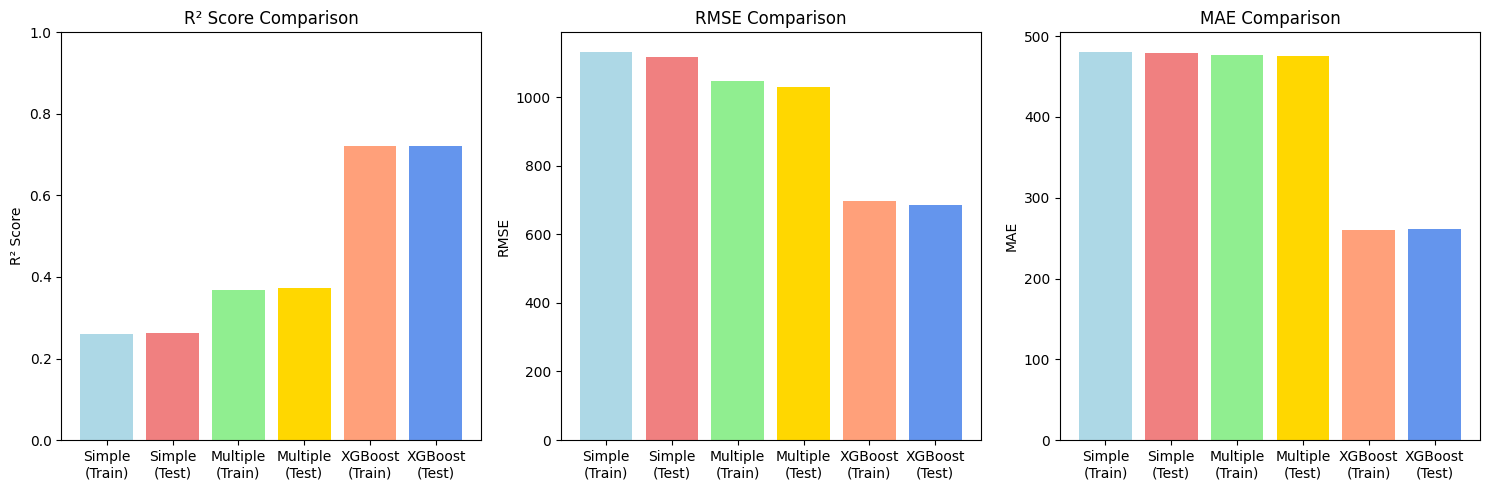

In [62]:
# Performance comparison visualization
metrics_comparison = pd.DataFrame({
    'Simple_Train': [simple_train_metrics['R2'], simple_train_metrics['RMSE'], simple_train_metrics['MAE']],
    'Simple_Test': [simple_test_metrics['R2'], simple_test_metrics['RMSE'], simple_test_metrics['MAE']],
    'Multiple_Train': [multiple_train_metrics['R2'], multiple_train_metrics['RMSE'], multiple_train_metrics['MAE']],
    'Multiple_Test': [multiple_test_metrics['R2'], multiple_test_metrics['RMSE'], multiple_test_metrics['MAE']],
    'XGBoost_Train': [xgboost_train_metrics['R2'], xgboost_train_metrics['RMSE'], xgboost_train_metrics['MAE']],
    'XGBoost_Test': [xgboost_test_metrics['R2'], xgboost_test_metrics['RMSE'], xgboost_test_metrics['MAE']]
})

print("Performance Comparison:")
print(metrics_comparison)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# R² comparison
r2_data = [simple_train_metrics['R2'], simple_test_metrics['R2'],
           multiple_train_metrics['R2'], multiple_test_metrics['R2'], xgboost_train_metrics['R2'], xgboost_test_metrics['R2']]
labels = ['Simple\n(Train)', 'Simple\n(Test)', 'Multiple\n(Train)', 'Multiple\n(Test)', 'XGBoost\n(Train)', 'XGBoost\n(Test)']
axes[0].bar(labels, r2_data, color=['lightblue', 'lightcoral', 'lightgreen', 'gold', 'lightsalmon', 'cornflowerblue'])
axes[0].set_title('R² Score Comparison')
axes[0].set_ylabel('R² Score')
axes[0].set_ylim(0, 1)

# RMSE comparison
rmse_data = [simple_train_metrics['RMSE'], simple_test_metrics['RMSE'],
             multiple_train_metrics['RMSE'], multiple_test_metrics['RMSE'],  xgboost_train_metrics['RMSE'], xgboost_test_metrics['RMSE']]
axes[1].bar(labels, rmse_data, color=['lightblue', 'lightcoral', 'lightgreen', 'gold', 'lightsalmon', 'cornflowerblue'])
axes[1].set_title('RMSE Comparison')
axes[1].set_ylabel('RMSE')

# MAE comparison
mae_data = [simple_train_metrics['MAE'], simple_test_metrics['MAE'],
            multiple_train_metrics['MAE'], multiple_test_metrics['MAE'], xgboost_train_metrics['MAE'],xgboost_test_metrics['MAE']]
axes[2].bar(labels, mae_data, color=['lightblue', 'lightcoral', 'lightgreen', 'gold', 'lightsalmon', 'cornflowerblue'])
axes[2].set_title('MAE Comparison')
axes[2].set_ylabel('MAE')

plt.tight_layout()
plt.show()

In [63]:
# Create a file to use on streamlit with comparasion metrics
import json
# Combine all metrics
all_metrics = {
    "XGBoost": {
        "Train": xgboost_train_metrics,
        "Test": xgboost_test_metrics
    },
    "LinearRegression": {
        "Train": multiple_train_metrics,
        "Test": multiple_test_metrics
    }
}
# Save to one file
with open("model_metrics.json", "w") as f:
    json.dump(all_metrics, f, indent=4)


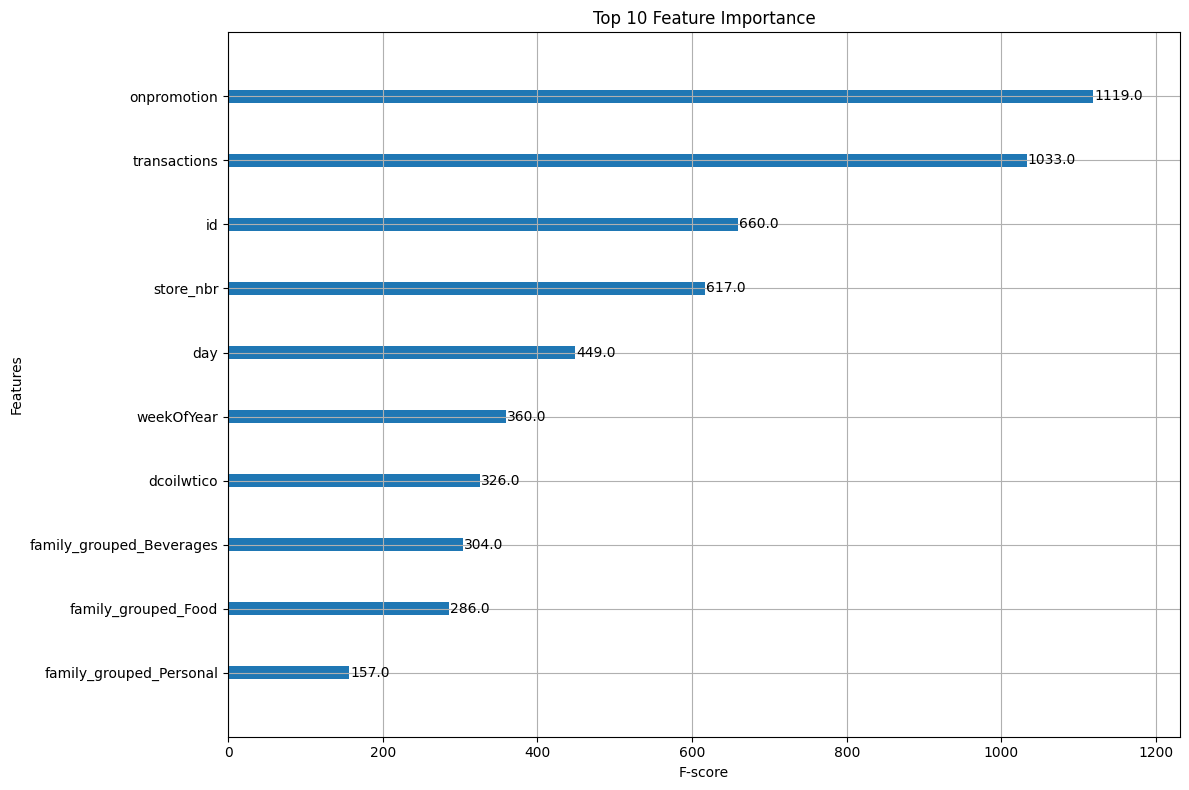

In [64]:
plt.figure(figsize=(12, 8))
# Plot feature importance, showing top 10 features
xgb.plot_importance(model, max_num_features=10, ax=plt.gca()) # Use model directly and specify max_num_features
plt.title("Top 10 Feature Importance")
plt.xlabel("F-score") # Common label for XGBoost feature importance
plt.ylabel("Features")
plt.tight_layout()
plt.show()

Cross Validatipon of RGBoost Model


In [65]:
# Defining and Train XGBoost model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree= 0.8,
    random_state=42,
    n_jobs=-1
)
# 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validate using R² (you can change scoring to 'neg_mean_absolute_error' or 'neg_root_mean_squared_error' too)
scores = cross_val_score(model, X, y, scoring='r2', cv=kf)

# Print results
print("=== Cross-Validation R² Scores ===")
for i, score in enumerate(scores):
    print(f"Fold {i+1}: R² = {score:.4f}")

print(f"\nAverage R² Score: {np.mean(scores):.4f}")
print(f"Standard Deviation: {np.std(scores):.4f}")

=== Cross-Validation R² Scores ===
Fold 1: R² = 0.7208
Fold 2: R² = 0.6983
Fold 3: R² = 0.7095
Fold 4: R² = 0.7207
Fold 5: R² = 0.7061

Average R² Score: 0.7110
Standard Deviation: 0.0087


Making Predictions on New Data

In [67]:
print("=== BUSINESS PREDICTION SCENARIOS ===")

model = xgb.XGBRegressor() # Initialize the model
model.load_model("xgb_sales_model.json") # Load the saved model

# STEP 1: Define sample business scenarios with realistic values
# Ensure all lists have the same length
sample_sales = pd.DataFrame({
    'id': [1234567, 2345678],
    'store_nbr': [5, 38],
    'onpromotion': [15, 100],
    'dcoilwtico': [55.2, 47.8],
    'transactions': [800, 1600],
    'month': [11, 12],
    'year': [2016, 2017],
    'weekOfYear': [20, 50],
    'quarter': [3, 4],
    'day': [4, 5],  # Midweek and Weekend
    'family_grouped_Food': [1, 0],
    'family_grouped_Beverages': [0, 1],
    'family_grouped_Home': [0, 0],
    'family_grouped_Personal': [0, 0],
    'family_grouped_Other': [0, 0],
    'city_grouped_Guayaquil': [1, 0],
    'city_grouped_Quito': [0, 1],
    'city_grouped_Other': [0, 0],
    'state_Guayas': [1, 0],
    'state_Pichincha': [0, 1],
    # Add other required dummy fields if needed...
})

# STEP 2: Derive engineered categorical columns
df_clean = df_encoded.copy() # Use df_encoded to map the WeekPart and MonthSeason
sample_sales['WeekPart'] = pd.cut(sample_sales['day'], bins=[-1, 2, 4, 6],
                                   labels=['EarlyWeek', 'MidWeek', 'Weekend'])

season_map = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
}
sample_sales['MonthSeason'] = sample_sales['month'].map(season_map)

sample_sales['holiday_type'] = 'NotHoliday'

# STEP 3: One-hot encode engineered features
onehot_cols = ['WeekPart', 'MonthSeason', 'holiday_type']
encoded = pd.get_dummies(sample_sales, columns=onehot_cols, prefix=onehot_cols, drop_first=True)

# STEP 4: Align columns with training set
for col in X_train.columns:
    if col not in encoded.columns:
        encoded[col] = 0

# Ensure the order of columns in 'encoded' matches 'X_train.columns'
encoded = encoded[X_train.columns]

# STEP 5: Predict
predicted_sales = model.predict(encoded)

# STEP 6: Display Results
sample_sales['Predicted_Sales_Units'] = predicted_sales

print("\nPrediction Results:")
print(sample_sales[['store_nbr', 'day', 'month', 'year', 'onpromotion', 'Predicted_Sales_Units']])

print("\nBusiness Interpretation:")
for i, row in sample_sales.iterrows():
    print(f"Scenario {i+1}: Store {row['store_nbr']} on {row['year']}-{row['month']}-{row['day']} with {row['onpromotion']} items on promotion")
    print(f"          Predicted Sales Units: {row['Predicted_Sales_Units']:,.2f}")
    print()

=== BUSINESS PREDICTION SCENARIOS ===

Prediction Results:
   store_nbr  day  month  year  onpromotion  Predicted_Sales_Units
0          5    4     11  2016           15             817.733582
1         38    5     12  2017          100            5038.194824

Business Interpretation:
Scenario 1: Store 5 on 2016-11-4 with 15 items on promotion
          Predicted Sales Units: 817.73

Scenario 2: Store 38 on 2017-12-5 with 100 items on promotion
          Predicted Sales Units: 5,038.19



In [68]:
# A/B scenarios (promotion vs. no promotion)
# Base scenario: same store/date, just toggle 'onpromotion'
base_features = {
    'id': 1234567,
    'store_nbr': 5,
    'dcoilwtico': 60.0,
    'transactions': 1200,
    'month': 12,
    'year': 2017,
    'weekOfYear': 50,
    'quarter': 4,
    'day': 5,  # Friday (assume weekend)

    # Product category: Food
    'family_grouped_Food': 1,
    'family_grouped_Beverages': 0,
    'family_grouped_Home': 0,
    'family_grouped_Personal': 0,
    'family_grouped_Other': 0,

    # City/state dummy variables
    'city_grouped_Guayaquil': 1,
    'city_grouped_Quito': 0,
    'city_grouped_Other': 0,
    'state_Guayas': 1,
    'state_Pichincha': 0,

    # Week part and season
    'WeekPart_MidWeek': 0,
    'WeekPart_Weekend': 1,
    'MonthSeason_Spring': 0,
    'MonthSeason_Summer': 0,
    'MonthSeason_Winter': 1,

    # Holiday dummy vars
    'holiday_type_NotHoliday': 1,
    'holiday_type_Bridge': 0,
    'holiday_type_Event': 0,
    'holiday_type_Holiday': 0,
    'holiday_type_Transfer': 0,
    'holiday_type_Work Day': 0,
}

# Create two copies: one with promotion, one without
scenario_with_promo = base_features.copy()
scenario_with_promo['onpromotion'] = 100

scenario_no_promo = base_features.copy()
scenario_no_promo['onpromotion'] = 0

# Convert to DataFrame
scenarios_df = pd.DataFrame([scenario_with_promo, scenario_no_promo])

# Fill any missing training columns
for col in X_train.columns:
    if col not in scenarios_df.columns:
        scenarios_df[col] = 0

# Match column order
scenarios_df = scenarios_df[X_train.columns]

# Predict
predicted_sales = model.predict(scenarios_df)

# Display results
scenarios_df['Predicted_Sales'] = predicted_sales
scenarios_df['Promotion_Status'] = ['With Promotion', 'No Promotion']

print("\n=== Promotion Scenario Comparison ===")
print(scenarios_df[['onpromotion', 'Promotion_Status', 'Predicted_Sales']])

increase = scenarios_df.loc[0, 'Predicted_Sales'] - scenarios_df.loc[1, 'Predicted_Sales']
pct_change = 100 * increase / scenarios_df.loc[1, 'Predicted_Sales']

print(f"\n📈 Impact of Promotion:")
print(f"- Increase in predicted sales: {increase:.2f} units")
print(f"- Percentage increase: {pct_change:.2f}%")



=== Promotion Scenario Comparison ===
   onpromotion Promotion_Status  Predicted_Sales
0          100   With Promotion      2037.943481
1            0     No Promotion       230.178619

📈 Impact of Promotion:
- Increase in predicted sales: 1807.76 units
- Percentage increase: 785.37%


## 8. Model Limitations and Business Considerations

In [69]:
# Check for potential overfitting on RGBoost model
print("=== MODEL VALIDATION SUMMARY ===")
print(f"Training R²: {xgboost_train_metrics['R2']:.4f}")
print(f"Testing R²: {xgboost_test_metrics['R2']:.4f}")
print(f"Difference: {xgboost_train_metrics['R2'] - xgboost_test_metrics['R2']:}")

if abs(xgboost_train_metrics['R2'] - xgboost_test_metrics['R2']) < 0.05:
    print(" Model shows good generalization (low overfitting)")
else:
    print("Model may be overfitting (significant difference between train/test performance)")

print("\n=== BUSINESS INSIGHTS ===")

# Feature importance insights
top_features = coefficients_df.head(4)
print("\nTop 4 Most Important Factors for Sales Demand Increase:")
for idx, row in top_features.iterrows():
    direction = "increases" if row['Coefficient'] > 0 else "decreases"
    print(f"  {idx+1}. {row['Feature']}: {direction} sales (coefficient: {row['Coefficient']:.4f})")

print("\n=== MODEL COMPARISON SUMMARY ===")

print(f"The Simple Linear Regression model explained approximately {simple_train_metrics['R2'] * 100:.2f}% "
      f"of the variance in sales (R² ≈ {simple_train_metrics['R2']:.4f}).")
print(f"The Multiple Linear Regression model explained approximately {multiple_train_metrics['R2'] * 100:.2f}% "
      f"of the variance in sales (R² ≈ {multiple_train_metrics['R2']:.4f}).")
print(f"The RGBoost model explained approximately {xgboost_test_metrics['R2'] * 100:.2f}% "
      f"of the variance in sales (R² ≈ {xgboost_test_metrics['R2']:.4f}).")

if xgboost_test_metrics['R2'] > multiple_train_metrics['R2']:
    print("This indicates that RGBoost better captures complex, non-linear relationships in the data,")
    print("making it more suitable for accurate sales forecasting in dynamic retail environments.")
else:
    print("Interestingly, the RGBoost model did not outperform the linear model significantly,")
    print("suggesting that simpler linear relationships may dominate in this dataset or model tuning is required.")

print("\n=== BUSINESS RECOMMENDATIONS ===")
print("1. Leverage the RGBoost model to guide inventory planning and promotional strategies at store level.")
print("2. Retrain the model regularly (e.g., monthly or quarterly) using the most recent sales and promotion data.")
print("3. Monitor feature importance and sales prediction errors by region, product category, and time period to refine forecasting.")
print("4. Integrate external data sources (e.g., holidays, inflation, competitor pricing) to further enhance model accuracy.")
print("5. Use scenario simulation (e.g., with and without promotions) to support data-driven business decisions and optimize campaigns.")
print("6. Combine model insights with expert domain knowledge from marketing and supply chain teams for final decision-making.")


=== MODEL VALIDATION SUMMARY ===
Training R²: 0.7205
Testing R²: 0.7205
Difference: -1.5708840193529028e-05
 Model shows good generalization (low overfitting)

=== BUSINESS INSIGHTS ===

Top 4 Most Important Factors for Sales Demand Increase:
  3. onpromotion: increases sales (coefficient: 595.2064)
  7. year: increases sales (coefficient: 356.7223)
  1. id: decreases sales (coefficient: -344.8176)
  22. family_grouped_Beverages: increases sales (coefficient: 308.3998)

=== MODEL COMPARISON SUMMARY ===
The Simple Linear Regression model explained approximately 25.98% of the variance in sales (R² ≈ 0.2598).
The Multiple Linear Regression model explained approximately 36.83% of the variance in sales (R² ≈ 0.3683).
The RGBoost model explained approximately 72.05% of the variance in sales (R² ≈ 0.7205).
This indicates that RGBoost better captures complex, non-linear relationships in the data,
making it more suitable for accurate sales forecasting in dynamic retail environments.

=== BUSINE